<H1 style="text-align: center">Detecting Malaria invasion in cells using Machine Learning Techniques</H1>
<img src="cover_image.jpg" width=400 height=500 /> <br> </br>

**The invasion of Malaria Parasite in human body brings noticeable changes in Red Blood Cells including loss of normal discoid shape and increasing rigidity of membrane [1]. The changes can be diagnosed microscopically. In this, project we would aim to use certain machine learning techniques to identify the changes in the Red Blood cells after it is invaded by malaria parasite and classify those cells as infected or not. Here, the problem is approached under Supervised learning where cell will be classified as infected or not under binary classification based on the learning from data and corresponding labels. Certain classification techniques are available. Here, we would be using K Nearest Neighbors and Deep Learning using Convolutional Neural Networks (CNN) to classify the cell images. This would allow us to determine rapidly and efficiently if a cell is infected by malaria parasite or not and contributes towards automated microscopy.<br></br>
Malaria is one of the serious diseases in world, caused by Plasmodium parasites. As per WHO [2], malaria has accounted for total 229 million cases and 409000 deaths in 2019 alone with children aged under 5 years being the most vulnerable group who accounted for 67 % of malaria deaths worldwide. The symptoms get severe with time and if not treated within 24hours, it can progress to severe illness, often leading to death. The parasite is transmitted through the bite of female Anopheles mosquitoes.<br></br>
Motivation for this project involves the number of deaths especially in young children and lack of available resources in certain places for timely diagnosis and treatment of the disease. This requires trained experts and microscopist personal to analyze the blood sample manually to detect malaria parasite. Intelligent models can predict the infected cells way faster and efficiently leading to better diagnosis, treatment and ultimately saving lives.**

1.	Mohandas, N., An, X. Malaria and human red blood cells. Med Microbiol Immunol 201, 593–598 (2012). https://doi.org/10.1007/s00430-012-0272-2. 

2.	https://www.who.int/news-room/fact-sheets/detail/malaria


In [1]:
## Mounting Drive on Google Colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
## Unzipping the dataset of cell images and listing the folders.
%%time
!unzip -uq "/content/drive/My Drive/cell_images.zip"
!ls /content/cell_images

Parasitized  Uninfected
CPU times: user 86 ms, sys: 27.8 ms, total: 114 ms
Wall time: 10.8 s


# Import Libraries and Data

In [3]:
import pandas as pd # for data mnaipulations and tables
import numpy as np # for numerical operations on image arrays
import matplotlib.pyplot as plt  # for visualisations and plots
import os # for os level operations
import timeit # to keep track of time taken in execution
from keras.preprocessing.image import img_to_array # keras functions to convert image into numpy array
import cv2 # for image related operations and processing
import keras # for deep learning 

In [4]:
# Checking unzipped image files

inf_path = "/content/cell_images/Parasitized"
uninf_path = "/content/cell_images/Uninfected"
infected = os.listdir(inf_path)
uninfected = os.listdir(uninf_path)

# Removing unwanted files
infected.remove('Thumbs.db')
uninfected.remove('Thumbs.db')

# Number of files
print(len(infected))
print(len(uninfected))

13779
13779


# Data PreProcessing

*   This Dataset is taken from the official NIH Website https://ceb.nlm.nih.gov/repositories/malaria-datasets/. The dataset contains a total of 27,558 cell images with equal instances of parasitized and uninfected cells. As, there are equal number of instances for infected and uninfected images, the dataset is balanced. The data was collected as part of Malaria Screener research activity.<br></br>
*   The Dataset contains 2 folders – Parasitized and uninfected<br></br>
*   The images are colored with 3 channels- Red, Green and Blue (RGB) and are of diferent sizes in terms of pixels, so we resize every image to 32*32 pixel. This increases loading efficiency as well as maintains uniformity of data.
*   Labels are created while loading images from respective folders.
*   Class 0 - Uninfected
*   Class 1 - Infected
*   Loading - The images were loaded from the respective folders and were assigned a label of 0 (uninfected) and 1(infected) while loading.
*	Resizing - To ensure uniform data, each image was resized to 32x32 pixels and loaded to numpy arrays.
*	Shuffling - The images are loaded in an order, first infected cells, and then uninfected cells. To obtain a randomized dataset, we shuffle the images.
*	Visualizing data- for better understanding. We can see deformed infected cells.

### Data Loading, Resizing and Shuffling

In [5]:
# Loading images in a list after resizing and labeling at the same time
start = timeit.default_timer()
array = []
label = []
for i,u in zip(infected,uninfected):
    try:
        array.append(img_to_array(cv2.resize(plt.imread(inf_path+'/'+i), (32,32))))  # Loading of image data is faster after resizing
        array.append(img_to_array(cv2.resize(plt.imread(uninf_path+'/'+u), (32,32))))
        label.append(1)
        label.append(0)
    except:
        pass

array = np.array(array)
labels = np.array(label)
print(array.shape)
print(labels.shape)

stop = timeit.default_timer()
print('Time: ', stop - start)

(27558, 32, 32, 3)
(27558,)
Time:  44.76593358299999


Above output shows, 27558 images with each image of 32x32 pixels and 3 channels(RGB).
And, another array containing labels of 27558 images

In [6]:
# The images are loaded in an order, first infected cells and then uninfected cells.
# We should shuffle the images randomly to remove any biases and for better learning of model

from sklearn.utils import shuffle
idx = np.arange(array.shape[0])
print("Indexes before shuffle")
print(idx)

idx = shuffle(idx)
print("Indexes after shuffle")
print(idx)

# Applying indexes on data to shuffle it
array = array[idx]
labels = labels[idx]

Indexes before shuffle
[    0     1     2 ... 27555 27556 27557]
Indexes after shuffle
[ 9013 26774  2286 ... 17872  9546 20462]


### Visualising Data

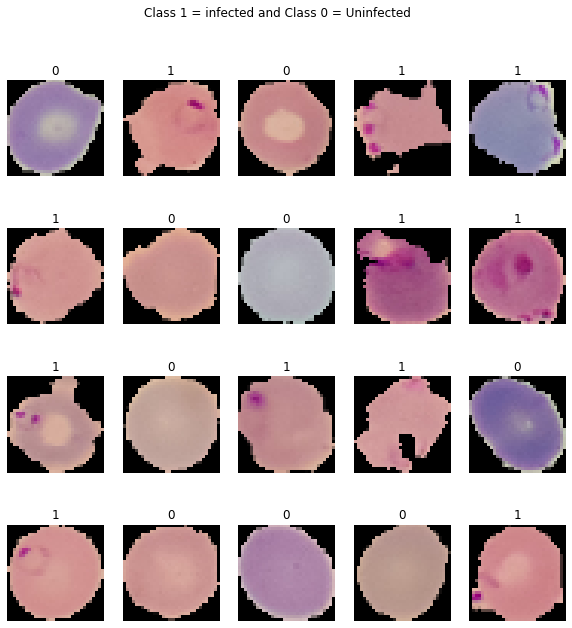

In [ ]:
L = 4
W = 5
fig,ax = plt.subplots(L,W,figsize=(10,10))
ax=ax.ravel()
for i in range(L*W):
    ind = np.random.randint(len(array))
    ax[i].imshow(array[ind])
    ax[i].axis('off')
    ax[i].set_title(labels[ind])
plt.suptitle("Class 1 = infected and Class 0 = Uninfected")
plt.subplots_adjust(hspace=0.5)

### Target Class Encoding

As the target/output has binary output labels 0 and 1. They are already encoded to categorical class of 0 and 1, where 0 means the cell is uninfected and 1 means the cell is infected

# Training KNN Model

Splitting Data into test and training Data.
70 % training and 30% test data

In [7]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(array,labels,test_size=0.3,random_state = 42)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(19290, 32, 32, 3)
(8268, 32, 32, 3)
(19290,)
(8268,)


Flatten Data to feed to KNN model

In [8]:
X_train_flatten = X_train.flatten().reshape(X_train.shape[0],3072) # Features of RGB images are flattened to 32x32x3 = 3072
X_test_flatten = X_test.flatten().reshape(X_test.shape[0],3072)
print(X_train_flatten.shape)
print(X_test_flatten.shape)

(19290, 3072)
(8268, 3072)


In [9]:
# Function to create a KNN classifier

from sklearn.neighbors import KNeighborsClassifier
def knn(neighbors,X_train,y_train):
  '''Creates a KNN Model
    ----------
    neighbors : Number of neighbors for KNN
    X_train: Training set of independent variables
    y_train:Training set of dependent variables

    Returns
    -------
    object
        KNN Model
    '''
  knn = KNeighborsClassifier(n_neighbors=neighbors)
  return knn.fit(X_train, y_train)

#### Experimenting with different values of neighbors in KNN

In [ ]:
# Accuracies with different number of neighbors and default Eucledian Distance as Metric
start = timeit.default_timer()
for k in [1,3,5,7]:
  knn_model = knn(neighbors = k ,X_train =X_train_flatten ,y_train =y_train)
  #pred = knn_model.predict(X_test_gray_flatten)
  acc = knn_model.score(X_test_flatten,y_test)
  print("Accuracy with {0} Neighbors {1}:".format(k,acc))
stop = timeit.default_timer()
print('Time: ', stop - start)

Accuracy with 1 Neighbors 0.5892597968069666:
Accuracy with 3 Neighbors 0.5991775520077407:
Accuracy with 5 Neighbors 0.6008708272859217:
Accuracy with 7 Neighbors 0.5942186744073537:
Time:  3715.6657229569996


#### Experimenting with different Distance Metrics. Eg- Manhattan and Chebyshev

In [10]:
from sklearn.neighbors import KNeighborsClassifier

def knn_metric(neighbors,X_train,X_test,y_test,y_train,dist='euclidean'):
    '''
    Creates a KNN Model with given specifications
    ----------
    neighbors : Number of neighbors for KNN
    metric: Distance function. (By default Euclidean)
    X_train: Training set of independent variables
    y_train:Training set of dependent variables
    X_test: Testing set of independent variables
    y_test: Testing set of dependent variables

    Returns
    -------
    Object
        KNN classifier model
    '''
    model = KNeighborsClassifier(n_neighbors=neighbors,metric=dist)
    model.fit(X_train, y_train)
    return model.score(X_test,y_test)

In [ ]:
# Finding accuracy with different Distance parameters
start = timeit.default_timer()

scores_dist = {}
for d in ['manhattan','chebyshev']:
    acc = knn_metric(neighbors = 5,dist =d ,X_train = X_train_flatten,X_test = X_test_flatten,y_test = y_test, 
                     y_train = y_train)
    scores_dist[d] = acc
print(scores_dist)

stop = timeit.default_timer()
print('Time: ', stop - start)

{'manhattan': 0.5905902273826802, 'chebyshev': 0.5257619738751814}
Time:  1418.401174786999


#### Evaluating using n-fold cross validation

In [ ]:
from sklearn.model_selection import KFold

def kf_output(neighbors,x,y,kf):
    '''Calculates performance score for given number of folds, their average and standard deviation
    ----------
    neighbors:int -> list of nuber of neighbors to tune upon
    x: numpy array -> independent features
    y: numpy array -> dependent features
    kf: object of KFold

    Returns
    -------
    Dictionary
        Average accuracy score for given number of folds for different neighbors
    '''

    neighbors_kfold = {}
    #splits = kf.split(x)

    for n in neighbors:
        splits = kf.split(x)
        split_accuracies = []
        for train_indicies,test_indicies in splits:
            x_train, x_test = x[train_indicies], x[test_indicies]
            y_train,y_test = y[train_indicies], y[test_indicies]

            #Storing values of each fold split into lists
            score = knn_metric(neighbors = n, X_train = x_train,X_test = x_test, y_train=y_train, y_test=y_test)
            split_accuracies.append(score)
        
        neighbors_kfold[n] = np.mean(split_accuracies)
    
    return neighbors_kfold

In [ ]:
# Running n-fold validation for 5 splits using different number of neighbors
start = timeit.default_timer()

kf = KFold(n_splits=5)
out = kf_output(neighbors=[1,3,5,7,9], x=array.flatten().reshape(array.shape[0],array.shape[1]*array.shape[2]*array.shape[3]),
                y=labels, kf=kf)

stop = timeit.default_timer()

print('Time: ', stop - start)

Time:  23154.787767982998


In [ ]:
print(out)

{1: 0.5869440825434499, 3: 0.5964510482926482, 5: 0.5972133382002323, 7: 0.5963061803560052, 9: 0.5946005205580395}


*From the experiments conducted above, we find that Euclidean distance best defines the similairty between the feature vectors in n-dimensional space for our problem out of other available distance metrics. We further performed hyperparameter tuning to identify optimum number of neighbors using n-fold cross validation and found n=5 would be a good choice.*

#### Running predictions on the model with best obtained parameters from above experiments

In [11]:
# Creating final KNN model with tuned parameters
final_model = KNeighborsClassifier(n_neighbors=5,metric='euclidean')
final_model.fit(X_train_flatten,y_train)
pred = final_model.predict(X_test_flatten)

In [12]:
# creating Classification Report
from sklearn.metrics import classification_report
report = classification_report(y_test,pred)
print(report)

              precision    recall  f1-score   support

           0       0.57      0.84      0.68      4139
           1       0.69      0.35      0.46      4129

    accuracy                           0.60      8268
   macro avg       0.63      0.60      0.57      8268
weighted avg       0.63      0.60      0.57      8268



In [13]:
# Creating Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true = y_test, y_pred = pred)
cm

array([[3486,  653],
       [2683, 1446]])

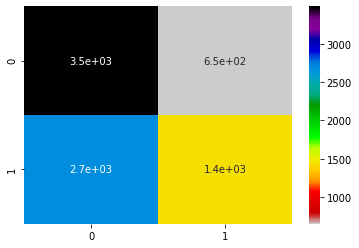

In [14]:
import seaborn as sns
s = sns.heatmap(cm, annot=True, cmap='nipy_spectral_r')

*From confusion matrix, we can deduce that the model predicts 3486 people correctly as not infected also called True Negatives (TN) and 653 uninfected people as infected and comes under category of Type I error, also called False Negatives (FP). Moreover, it detects 2683 infected people as uninfected or False Positive (FN) comes under category of Type II error and we always want to minimize this error. And 1446 infected people were correctly identified as infected or True positives (TP). We get an accuracy of 60% with a high type II error using KNN classifier.Also, we would like to have a high recall for infected class (class 1) as we wan't to correctly diagnose the infected patient. 
The results are not very good, as the type II error is quite high. A very large number of infected people were classified as uninfected, which is not good, thus not diagnosed well and can be dangerous for them.*

# Classification using convolutional Neural Network

In [ ]:
from keras.models import Sequential # Keras is an API that sits on top of tensor flow. Provides an easy way to build CNN and calls tensorflow in background
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, Dense, Flatten, Dropout
# Moving from left to right we perform convulation,Relu function for non-linearity, Downsampling or subsampling to compress using maxpooling by fetching the maximum pixel value,
# Average pooling performs pooling by averaging the value of pixels, dense to create neural network, Flatten just flattens our array to feed to Neural Net
# Dropout to perform regularization to reduce overfitting
from keras.optimizers import Adam # to perform optimisation and update weights of network.
from keras.callbacks import TensorBoard # to plot network

### Splitting Data into Test,Train and Validation set for CNN model

In [ ]:
# Splitting dataset into Test, Train and validation data
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(array,labels,test_size=0.25,random_state = 42) # split main dataset into 75% training and 25% test set
X_train,X_val,y_train,y_val = train_test_split(X_train,y_train,test_size=0.2,random_state = 42) # split train dataset into 80% training and 20% validation set

In [ ]:
input_shape = X_train.shape[1:]
input_shape

(32, 32, 3)

In [ ]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)
print(X_val.shape)
print(y_val.shape)

(16534, 32, 32, 3)
(6890, 32, 32, 3)
(16534,)
(6890,)
(4134, 32, 32, 3)
(4134,)


### Creating CNN Model

In [ ]:
def cnn(conv_l1_f,conv_l2_f,input_shape,pooling,drop_l1,drop_l2,neurons):
  '''Creates a CNN model with given specifications
    ----------
    conv_l1_f : Number of filters in first convolutional layer
    conv_l2_f: Number of filters in second convolutional layer
    input_shape: shape of input image in terms of pixels and channels (Eg. 32x32x3)
    pooling: Type of pooling to be used
    drop_l1: Dropout for first convolutional layer
    drop_l2: Dropout for second convolutional layer
    neurons: Number of neurons in dense layers

    Returns
    -------
    object
        CNN model
    '''
    cnn_model = Sequential()
    cnn_model.add(Conv2D(filters=conv_l1_f, kernel_size=(3,3), activation='relu',input_shape=input_shape)) # created first convulational layer
    cnn_model.add(Conv2D(filters=conv_l1_f, kernel_size=(3,3), activation='relu')) # created another convulational layer, no need to give input size this time as it is known from first layer
    cnn_model.add(pooling) #filter that downsamples the features has size of 2x2
    cnn_model.add(Dropout(drop_l1))
    
    # Creating a deep network, by creating more layers with different numebr of filters and dropouts
    cnn_model.add(Conv2D(filters = conv_l2_f, kernel_size=(3,3), activation='relu'))
    cnn_model.add(Conv2D(filters = conv_l2_f, kernel_size=(3,3), activation='relu'))
    cnn_model.add(pooling)
    cnn_model.add(Dropout(drop_l2))
    
    # Flattening
    cnn_model.add(Flatten())
    
    # Creating Hidden Layers
    cnn_model.add(Dense(units=neurons, activation='relu'))
    cnn_model.add(Dense(units=neurons, activation='relu'))
    
    # Creating OutPut Layer
    #cnn_model.add(Dense(units=2, activation='softmax')) # In case of multiclass classification, and gives probabiloty of belonging to a class. This is sufficed by softmax. relu is for more of a regression task
    cnn_model.add(Dense(units=1, activation='sigmoid')) # as we are doing binary classification, so sigmoid.
    return cnn_model

In [ ]:
# creating model configuration by experimenting with different parameters, using max pooling as default initially
# Tuning CNN model hyperparameters

conv_l1_f = [32,64]
conv_l2_f = [64,128]
drop_l1 = [0.2,0.4]
drop_l2 = [0.4,0.5]
neurons = [512,1024]

In [ ]:
# Running model for different parameters for tuning

%%time
cl1 = []
cl2 = []
dl1 = []
dl2 = []
neuro = []
accu = []
val_accu = []
histo = []

for i in conv_l1_f:
    for j in conv_l2_f:
          for l in drop_l1:
              for m in drop_l2:
                  for n in neurons:
                      print(i,j,l,m,n)
                      cnn_model = cnn(conv_l1_f = i,conv_l2_f=j,input_shape=input_shape,pooling=MaxPooling2D(2,2),drop_l1 =l,
                                      drop_l2=m,neurons=n)
                      cnn_model.compile(loss = 'binary_crossentropy', optimizer = Adam(), metrics=['accuracy'])
                      hist = cnn_model.fit(x=X_train,y=y_train,batch_size=32,epochs=30,shuffle=True,verbose=1,validation_data=(X_val,y_val))
                      cl1.append(i)
                      cl2.append(j)
                      dl1.append(l)
                      dl2.append(m)
                      neuro.append(n)
                      histo.append(hist)
                      ac = hist.history['accuracy']
                      accu.append(max(ac))
                      val_accu.append(hist.history['val_accuracy'][np.argmax(np.array(ac))])
                        
history={'conv_l1':cl1,'conv_l2':cl2,'drop_l1':dl1,'drop_l2':dl2,'neurons':neuro,'Train accuracy':accu,'Validation_accuracy':val_accu,'history':histo}   


32 64 0.2 0.4 512
Epoch 1/30
517/517 [==============================] - 10s 5ms/step - loss: 0.6326 - accuracy: 0.6145 - val_loss: 0.1678 - val_accuracy: 0.9487
Epoch 2/30
517/517 [==============================] - 2s 4ms/step - loss: 0.1677 - accuracy: 0.9472 - val_loss: 0.1568 - val_accuracy: 0.9485
Epoch 3/30
517/517 [==============================] - 2s 4ms/step - loss: 0.1515 - accuracy: 0.9540 - val_loss: 0.1569 - val_accuracy: 0.9550
Epoch 4/30
517/517 [==============================] - 2s 4ms/step - loss: 0.1481 - accuracy: 0.9525 - val_loss: 0.1458 - val_accuracy: 0.9533
Epoch 5/30
517/517 [==============================] - 2s 4ms/step - loss: 0.1349 - accuracy: 0.9576 - val_loss: 0.1339 - val_accuracy: 0.9545
Epoch 6/30
517/517 [==============================] - 2s 4ms/step - loss: 0.1460 - accuracy: 0.9520 - val_loss: 0.1356 - val_accuracy: 0.9569
Epoch 7/30
517/517 [==============================] - 2s 4ms/step - loss: 0.1275 - accuracy: 0.9583 - val_loss: 0.1347 - val_accu

In [ ]:
# Visualising the best accuracy using different Network parameters in a pandas dataframe
h = pd.DataFrame(history)
h.sort_values(by='Train accuracy',ascending=False)

,conv_l1,conv_l2,drop_l1,drop_l2,neurons,Train accuracy,Validation_accuracy,history
24,64,128,0.2,0.4,512,0.980404,0.950169,<tensorflow.python.keras.callbacks.History obj...
9,32,128,0.2,0.4,1024,0.980283,0.953072,<tensorflow.python.keras.callbacks.History obj...
8,32,128,0.2,0.4,512,0.978106,0.952588,<tensorflow.python.keras.callbacks.History obj...
0,32,64,0.2,0.4,512,0.976896,0.957668,<tensorflow.python.keras.callbacks.History obj...
16,64,64,0.2,0.4,512,0.976049,0.952346,<tensorflow.python.keras.callbacks.History obj...
19,64,64,0.2,0.5,1024,0.975807,0.955491,<tensorflow.python.keras.callbacks.History obj...
26,64,128,0.2,0.5,512,0.975565,0.951863,<tensorflow.python.keras.callbacks.History obj...
10,32,128,0.2,0.5,512,0.975082,0.954282,<tensorflow.python.keras.callbacks.History obj...
25,64,128,0.2,0.4,1024,0.974900,0.954040,<tensorflow.python.keras.callbacks.History obj...
17,64,64,0.2,0.4,1024,0.974719,0.958394,<tensorflow.python.keras.callbacks.History obj...


### Experimenting with Pooling

---



##### Average pooling

In [ ]:
# Creating CNN model with the best parameters obtained from above experiment using Average Pooling for 50 epochs
cnn_model = cnn(conv_l1_f = 64,conv_l2_f = 128,input_shape=input_shape,pooling=AveragePooling2D(2,2),drop_l1 =0.2,
                                      drop_l2 = 0.4, neurons= 512)
cnn_model.compile(loss = 'binary_crossentropy', optimizer = Adam(), metrics=['accuracy'])
hist_avg_pool = cnn_model.fit(x=X_train,y=y_train,batch_size=32,epochs=50,shuffle=True,verbose=1,validation_data=(X_val,y_val))

Epoch 1/50
517/517 [==============================] - 4s 6ms/step - loss: 0.6940 - accuracy: 0.5124 - val_loss: 0.6938 - val_accuracy: 0.4908
Epoch 2/50
517/517 [==============================] - 3s 6ms/step - loss: 0.6929 - accuracy: 0.5114 - val_loss: 0.6935 - val_accuracy: 0.4908
Epoch 3/50
517/517 [==============================] - 3s 6ms/step - loss: 0.6932 - accuracy: 0.5029 - val_loss: 0.6934 - val_accuracy: 0.4908
Epoch 4/50
517/517 [==============================] - 3s 6ms/step - loss: 0.6932 - accuracy: 0.5051 - val_loss: 0.6934 - val_accuracy: 0.4908
Epoch 5/50
517/517 [==============================] - 3s 6ms/step - loss: 0.6929 - accuracy: 0.5098 - val_loss: 0.6934 - val_accuracy: 0.4908
Epoch 6/50
517/517 [==============================] - 3s 6ms/step - loss: 0.6906 - accuracy: 0.5279 - val_loss: 0.6905 - val_accuracy: 0.5910
Epoch 7/50
517/517 [==============================] - 3s 6ms/step - loss: 0.6226 - accuracy: 0.6362 - val_loss: 0.2581 - val_accuracy: 0.9134
Epoch 

#### Max Pooling

In [ ]:
# Creating CNN model with the best parameters obtained from above experiment using Max Pooling with 50 epochs
cnn_model = cnn(conv_l1_f = 64,conv_l2_f = 128,input_shape=input_shape,pooling=MaxPooling2D(2,2),drop_l1 =0.2,
                                      drop_l2 = 0.4, neurons= 512)
cnn_model.compile(loss = 'binary_crossentropy', optimizer = Adam(), metrics=['accuracy'])
hist_max_pool = cnn_model.fit(x=X_train,y=y_train,batch_size=32,epochs=50,shuffle=True,verbose=1,validation_data=(X_val,y_val))

Epoch 1/50
517/517 [==============================] - 4s 7ms/step - loss: 0.6978 - accuracy: 0.4948 - val_loss: 0.6936 - val_accuracy: 0.4908
Epoch 2/50
517/517 [==============================] - 3s 6ms/step - loss: 0.6932 - accuracy: 0.5041 - val_loss: 0.6936 - val_accuracy: 0.4908
Epoch 3/50
517/517 [==============================] - 3s 6ms/step - loss: 0.6938 - accuracy: 0.5030 - val_loss: 0.6940 - val_accuracy: 0.4908
Epoch 4/50
517/517 [==============================] - 3s 6ms/step - loss: 0.6898 - accuracy: 0.5244 - val_loss: 0.4682 - val_accuracy: 0.7673
Epoch 5/50
517/517 [==============================] - 3s 6ms/step - loss: 0.3168 - accuracy: 0.8744 - val_loss: 0.1933 - val_accuracy: 0.9364
Epoch 6/50
517/517 [==============================] - 3s 6ms/step - loss: 0.1845 - accuracy: 0.9391 - val_loss: 0.1560 - val_accuracy: 0.9497
Epoch 7/50
517/517 [==============================] - 3s 6ms/step - loss: 0.1576 - accuracy: 0.9487 - val_loss: 0.1374 - val_accuracy: 0.9579
Epoch 

Text(0, 0.5, 'Training Accuracy')

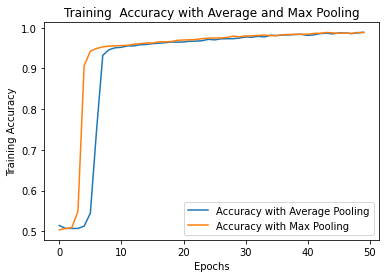

In [ ]:
# Comparing accuracy using Average and Max Pooling
accuracy_avg = hist_avg_pool.history['accuracy']
accuracy_max = hist_max_pool.history['accuracy']

epochs = range(len(accuracy_avg))

# Plotting the accuracies from both poolings
plt.plot(epochs, accuracy_avg, label='Accuracy with Average Pooling')
plt.plot(epochs, accuracy_max, label='Accuracy with Max Pooling')
plt.title('Training  Accuracy with Average and Max Pooling')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Training Accuracy")


*We run experiment to get best pooling parameter by comparing Max and Average Pooling. Above figure shows that max pooling starts giving better training results than average pooling and converges in less epochs.*

### Experiment without Dropout

In [ ]:
# Creating CNN model with the tuned hyperparameters without using Dropout
cnn_model = cnn(conv_l1_f = 64,conv_l2_f= 128,input_shape=input_shape,pooling=MaxPooling2D(2,2),drop_l1 =0,drop_l2=0,neurons=512)
cnn_model.compile(loss = 'binary_crossentropy', optimizer = Adam(), metrics=['accuracy'])
hist_no_drop = cnn_model.fit(x=X_train,y=y_train,batch_size=32,epochs=50,shuffle=True,verbose=1,validation_data=(X_val,y_val))

Epoch 1/50
517/517 [==============================] - 4s 6ms/step - loss: 0.6772 - accuracy: 0.5426 - val_loss: 0.2335 - val_accuracy: 0.9122
Epoch 2/50
517/517 [==============================] - 3s 6ms/step - loss: 0.1846 - accuracy: 0.9403 - val_loss: 0.1384 - val_accuracy: 0.9565
Epoch 3/50
517/517 [==============================] - 3s 6ms/step - loss: 0.1403 - accuracy: 0.9569 - val_loss: 0.1356 - val_accuracy: 0.9562
Epoch 4/50
517/517 [==============================] - 3s 6ms/step - loss: 0.1368 - accuracy: 0.9564 - val_loss: 0.1359 - val_accuracy: 0.9550
Epoch 5/50
517/517 [==============================] - 3s 6ms/step - loss: 0.1227 - accuracy: 0.9586 - val_loss: 0.1544 - val_accuracy: 0.9444
Epoch 6/50
517/517 [==============================] - 3s 6ms/step - loss: 0.1205 - accuracy: 0.9601 - val_loss: 0.1267 - val_accuracy: 0.9557
Epoch 7/50
517/517 [==============================] - 3s 6ms/step - loss: 0.1155 - accuracy: 0.9589 - val_loss: 0.1365 - val_accuracy: 0.9531
Epoch 

In [ ]:
max(hist_no_drop.history['accuracy'])

0.9988508820533752

In [ ]:
hist_no_drop.history['val_accuracy'][np.argmax(np.array(hist_no_drop.history['accuracy']))]

0.9421867728233337

In [ ]:
# Visualising the sorted accuracies when no dropout is used
pd.DataFrame({'Training accuracy':hist_no_drop.history['accuracy'], 'Validation Accuracy':hist_no_drop.history['val_accuracy']}).sort_values(by='Training accuracy',ascending=False)

,Training accuracy,Validation Accuracy
42,0.998851,0.942187
47,0.998367,0.946541
43,0.998186,0.946057
37,0.998065,0.950169
49,0.997702,0.946299
33,0.997641,0.949444
46,0.997157,0.944606
48,0.997097,0.947992
44,0.996976,0.934930
36,0.996553,0.950411


*We Receive a high Training accuracy but comparetively low validation accuracy to the case where dropout was used. Showing that wihtout dropout or regularization, overfitting increases.*


### Final Model with Tuned hyperparameters

In [ ]:
# Creating final CNN model from tune parameters obtained from different experiments andfor 100 epochs
cnn_model = cnn(conv_l1_f = 64,conv_l2_f = 128,input_shape=input_shape,pooling=MaxPooling2D(2,2),drop_l1 =0.2,
                                      drop_l2 = 0.4, neurons= 512)
cnn_model.compile(loss = 'binary_crossentropy', optimizer = Adam(), metrics=['accuracy'])
history = cnn_model.fit(x=X_train,y=y_train,batch_size=32,epochs=100,shuffle=True,verbose=1,validation_data=(X_val,y_val))

Epoch 1/100
517/517 [==============================] - 4s 6ms/step - loss: 0.6946 - accuracy: 0.5095 - val_loss: 0.6937 - val_accuracy: 0.4913
Epoch 2/100
517/517 [==============================] - 3s 6ms/step - loss: 0.6794 - accuracy: 0.5438 - val_loss: 0.2328 - val_accuracy: 0.9221
Epoch 3/100
517/517 [==============================] - 3s 6ms/step - loss: 0.2118 - accuracy: 0.9324 - val_loss: 0.1513 - val_accuracy: 0.9475
Epoch 4/100
517/517 [==============================] - 3s 6ms/step - loss: 0.1608 - accuracy: 0.9473 - val_loss: 0.1476 - val_accuracy: 0.9492
Epoch 5/100
517/517 [==============================] - 3s 6ms/step - loss: 0.1458 - accuracy: 0.9515 - val_loss: 0.1477 - val_accuracy: 0.9533
Epoch 6/100
517/517 [==============================] - 3s 6ms/step - loss: 0.1404 - accuracy: 0.9542 - val_loss: 0.1349 - val_accuracy: 0.9543
Epoch 7/100
517/517 [==============================] - 3s 6ms/step - loss: 0.1357 - accuracy: 0.9551 - val_loss: 0.1376 - val_accuracy: 0.9557

### CNN Model Evaluation

Text(0, 0.5, 'Accuracy')

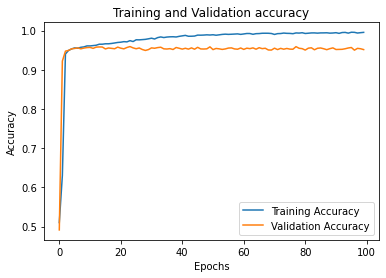

In [ ]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(accuracy))

plt.plot(epochs, accuracy,  label='Training Accuracy')
plt.plot(epochs, val_accuracy, label='Validation Accuracy')
plt.title('Training and Validation accuracy')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Accuracy")

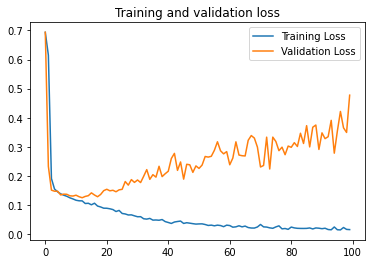

In [ ]:
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

*Above Figures shows the training, validation accuracies and losses, respectively. It can be observed that validation loss keeps on increasing with epochs, on the other hand training loss keeps decreasing, giving hint that model is overfitting after certain number of epochs.*

In [ ]:
#Running predictions for the test data
predicted_classes = cnn_model.predict_classes(X_test)
#get the indices to be plotted
y_true = y_test

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [ ]:
predicted_classes

array([[1],
       [0],
       [0],
       ...,
       [0],
       [1],
       [0]], dtype=int32)

[[3391   66]
 [ 209 3224]]


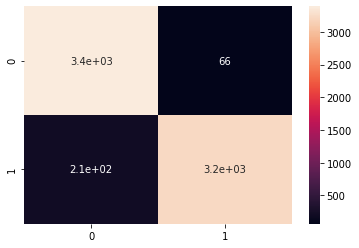

In [ ]:
# Creating Confusion Matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm = confusion_matrix(y_true, predicted_classes)
print(cm)
plt.figure()
sns.heatmap(cm, annot=True)

*From confusion matrix, we can deduce that the model predicts 3391 people correctly as not infected also called True Negatives (TN) and 66 uninfected people as infected comes under category of Type I error, also called False Positive (FP). Moreover, it detects 209 infected people as uninfected or False Negative (FN) which comes under category of type II error. And 3224 infected people were correctly identified as infected or True positives (TP).
There is a huge improvement seen in the type II error from KNN classifier, and only 209 infected peope were recognised as uninfected using the CNN. Therefore, a good recall score [TP/ (TP+FN)] of 0.93 for infected class and overall accuracy of 96% on test dataset.* 

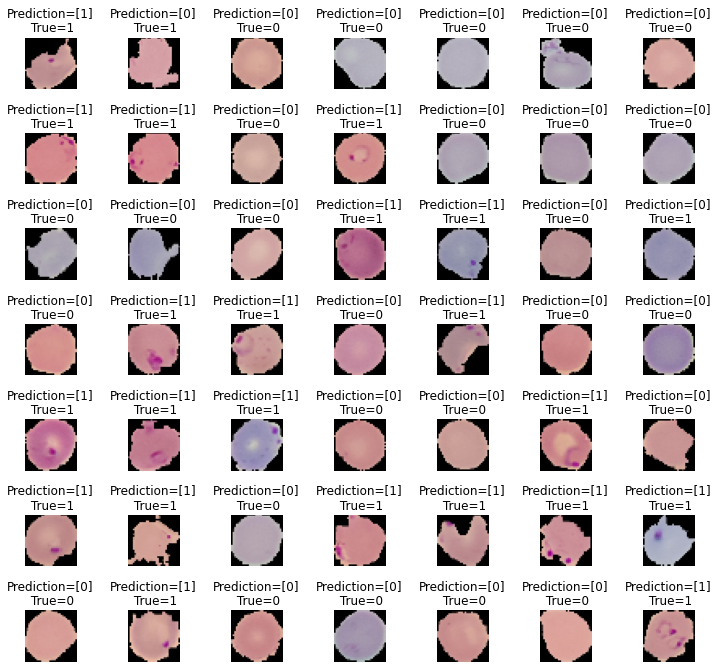

In [ ]:
# Visualising Data with actual and predicted values
L = 7
W = 7
fig, axes = plt.subplots(L, W, figsize = (12,12))
axes = axes.ravel() # 

for i in np.arange(0, L * W):  
    axes[i].imshow(X_test[i])
    axes[i].set_title("Prediction={}\n True={}".format(predicted_classes[i], y_true[i]))
    axes[i].axis('off')

plt.subplots_adjust(wspace=1)

## Reflection:

*We used two algorithms to solve this classification problem. One is k nearest neighbors or KNN and other is Convolutional Neural Network or CNN.
KNN classify objects based on the closest training examples in the feature space. During training phase, the feature vectors and labels are stored and is very fast, this makes data update very easy and we can introduce new images in dataset easily and fast. The classification occurs by assigning labels to a test image by the majority labels of it’s K nearest neighbors.
The results obtained with KNN are not very good, it gives and accuracy of 60%. Also, type II error are quite high with around 2683 patients detected as uninfected despite of being infected, and we do not want this thing. This is because KNN uses all features equally for similarity computing and as the feature vectors from images are of a high dimension, the euclidean distances in very high dimensional spaces become irrelevant due to well known curse of dimensionality, leading to the classification errors. Also, running the model for prediction consumes quite time, but KNN is quite simple and requires less parameters to be tuned, and training data can be updated very easily. For KNN we can also speedup the k-NN classifier by utilizing specialized data structures such as kd-trees.
On the other hand, CNN produces very good results. We achieved an accuracy of 96%. CNN is a very well-known method for image classification and uses several filters that work on scanning the image or features and effectively carry out dimensionality reduction. This makes CNN quite effective in image classification as images tends to have huge number of parameters in the image. We optimised several parameters for the CNN and experimented the dropout features that highlighted how we can reduce overfitting. Also, we concluded convergence results using different type of pooling. 
Much better results can be obtained by using methods like data augmentation in which the images are flipped, or brighten or darken etc., in other words different variations of an image are fed to model to enhance its intelligence and generalise the classification boundary. Therefore, deep learning methods prove to be performing very good for image classification tasks and further improvement can be done by more hyperparameter tuning, inbuilt tools from Keras like Keras Tuner and methods like data augmentation.*